ε	MSE Std	MSE Bias-Corr
0.4	0.0130	0.0124
0.5	0.0108	0.0158
0.6	0.0090	0.0186
0.7	0.0071	0.0101
0.8	0.0074	0.0089
0.9	0.0027	0.0096
1.0	0.0042	0.0051


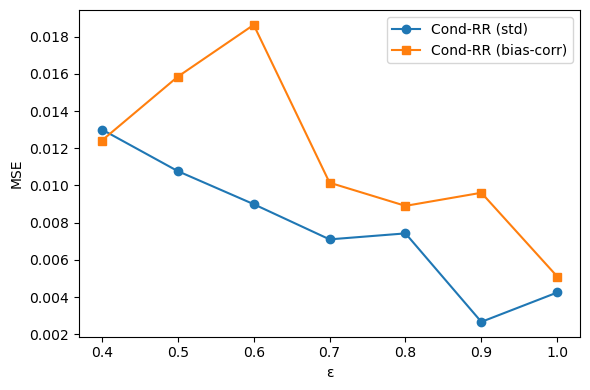

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

# --- GRR Primitives ---
def grr_perturb(x, domain, epsilon):
    exp_eps = np.exp(epsilon)
    k = len(domain)
    p = exp_eps / (exp_eps + k - 1)
    return x if np.random.rand() < p else np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    n = len(reports)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    q = 1.0 / (exp_eps + k - 1)
    counts = {v: 0 for v in domain}
    for r in reports:
        counts[r] += 1
    return {v: (counts[v] - n*q) / (n*(p - q)) for v in domain}

# --- Data generation & utility ---
def correlated_data_generator(n, p_corr, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.binomial(1, 0.5, size=n)
    flip = np.random.rand(n) >= p_corr
    Y = np.where(flip, 1 - X, X)
    return np.column_stack([X, Y])

def get_true_frequencies(data):
    return np.array([np.mean(data[:,i] == 1) for i in range(2)])

# --- Cond-RR variants ---
def cond_rr_estimate(data, epsilon, m):
    n = len(data); eps2 = epsilon/2
    spl = np.array([[grr_perturb(x, [0,1], eps2) for x in row] for row in data[:m]])
    counts = {(0,0):0,(0,1):0,(1,0):0,(1,1):0}
    for a,b in spl: counts[(a,b)] += 1
    Y = np.array([counts[k]/m for k in [(0,0),(0,1),(1,0),(1,1)]])
    p = np.exp(eps2)/(np.exp(eps2)+1); q = 1-p
    M = np.array([[p*p,p*q,q*p,q*q],
                  [p*q,p*p,q*q,p*q],
                  [q*p,q*q,p*p,p*q],
                  [q*q,q*p,p*q,p*p]])
    P = inv(M).dot(Y); P = np.clip(P,0,None); P /= P.sum()
    P00,P01,P10,P11 = P
    c2 = {0: P00/(P00+P01) if P00+P01>0 else 0.5,
          1: P10/(P10+P11) if P10+P11>0 else 0.5}
    c1 = {0: P00/(P00+P10) if P00+P10>0 else 0.5,
          1: P01/(P01+P11) if P01+P11>0 else 0.5}
    f1 = grr_estimate_frequencies(spl[:,0],[0,1],eps2)[1]
    f2 = grr_estimate_frequencies(spl[:,1],[0,1],eps2)[1]
    rr, syn = {1:[],2:[]}, {1:[],2:[]}
    for x1,x2 in data[m:]:
        if np.random.rand()<0.5:
            y1 = grr_perturb(x1,[0,1],epsilon)
            y2 = np.random.choice([0,1],p=[c2[y1],1-c2[y1]])
            rr[1].append(y1); syn[2].append(y2)
        else:
            y2 = grr_perturb(x2,[0,1],epsilon)
            y1 = np.random.choice([0,1],p=[c1[y2],1-c1[y2]])
            rr[2].append(y2); syn[1].append(y1)
    est = {}
    for j,f_s in [(1,f1),(2,f2)]:
        nr, ns = len(rr[j]), len(syn[j])
        f_rr = grr_estimate_frequencies(rr[j],[0,1],epsilon)[1] if nr>0 else 0
        f_syn = np.mean(syn[j]) if ns>0 else 0
        est[j] = (m*f_s + nr*f_rr + ns*f_syn) / n
    return np.array([est[1], est[2]])

def cond_rr_bias_corr(data, epsilon, m):
    n = len(data); eps2 = epsilon/2
    spl = np.array([[grr_perturb(x, [0,1], eps2) for x in row] for row in data[:m]])
    counts = {(0,0):0,(0,1):0,(1,0):0,(1,1):0}
    for a,b in spl: counts[(a,b)] += 1
    Y = np.array([counts[k]/m for k in [(0,0),(0,1),(1,0),(1,1)]])
    p = np.exp(eps2)/(np.exp(eps2)+1); q = 1-p
    M = np.array([[p*p,p*q,q*p,q*q],
                  [p*q,p*p,q*q,p*q],
                  [q*p,q*q,p*p,p*q],
                  [q*q,q*p,p*q,p*p]])
    P = inv(M).dot(Y); P = np.clip(P,0,None); P /= P.sum()
    P00,P01,P10,P11 = P
    c2 = {0: P00/(P00+P01) if P00+P01>0 else 0.5,
          1: P10/(P10+P11) if P10+P11>0 else 0.5}
    c1 = {0: P00/(P00+P10) if P00+P10>0 else 0.5,
          1: P01/(P01+P11) if P01+P11>0 else 0.5}
    f1 = grr_estimate_frequencies(spl[:,0],[0,1],eps2)[1]
    f2 = grr_estimate_frequencies(spl[:,1],[0,1],eps2)[1]
    rr, syn = {1:[],2:[]}, {1:[],2:[]}
    for x1,x2 in data[m:]:
        if np.random.rand()<0.5:
            y1 = grr_perturb(x1,[0,1],epsilon)
            y2 = np.random.choice([0,1],p=[c2[y1],1-c2[y1]])
            rr[1].append(y1); syn[2].append(y2)
        else:
            y2 = grr_perturb(x2,[0,1],epsilon)
            y1 = np.random.choice([0,1],p=[c1[y2],1-c1[y2]])
            rr[2].append(y2); syn[1].append(y1)
    est = {}
    for j,f_s in [(1,f1),(2,f2)]:
        nr, ns = len(rr[j]), len(syn[j])
        f_rr = grr_estimate_frequencies(rr[j],[0,1],epsilon)[1] if nr>0 else 0
        f_syn = grr_estimate_frequencies(syn[j],[0,1],epsilon)[1] if ns>0 else 0
        est[j] = (m*f_s + nr*f_rr + ns*f_syn) / n
    return np.array([est[1], est[2]])

# --- Simulation Loop & MSE collection ---
epsilons = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n = 1000
m = int(0.5 * n)
p_corr = 0.98
R = 20

all_mse_std = np.zeros((R, len(epsilons)))
all_mse_bc  = np.zeros((R, len(epsilons)))

for run in range(R):
    data = correlated_data_generator(n, p_corr, seed=run)
    true_f = get_true_frequencies(data)
    for i, eps in enumerate(epsilons):
        est_std = cond_rr_estimate(data, eps, m)
        est_bc  = cond_rr_bias_corr(data, eps, m)
        all_mse_std[run, i] = np.mean((est_std - true_f)**2)
        all_mse_bc[run, i]  = np.mean((est_bc  - true_f)**2)

mean_std = all_mse_std.mean(axis=0)
mean_bc  = all_mse_bc.mean(axis=0)

# --- Print & Plot ---
print("ε\tMSE Std\tMSE Bias-Corr")
for eps, ms, mb in zip(epsilons, mean_std, mean_bc):
    print(f"{eps:.1f}\t{ms:.4f}\t{mb:.4f}")

plt.figure(figsize=(6,4))
plt.plot(epsilons, mean_std, '-o', label='Cond-RR (std)')
plt.plot(epsilons, mean_bc,  '-s', label='Cond-RR (bias-corr)')
plt.xlabel('ε')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()


ε	MSE Std	MSE Bias-Corr
0.4	0.0019	0.0225
0.5	0.0017	0.0150
0.6	0.0013	0.0083
0.7	0.0007	0.0042
0.8	0.0006	0.0025
0.9	0.0005	0.0020
1.0	0.0005	0.0018


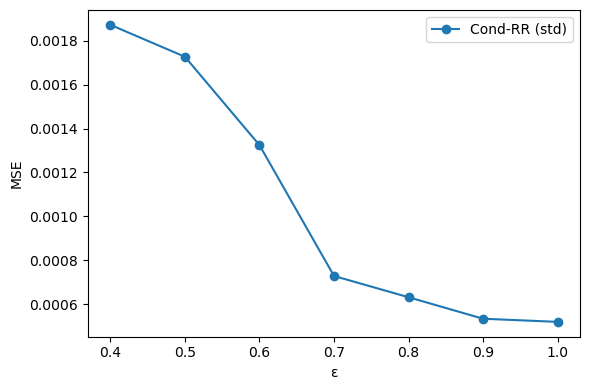

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

# --- GRR Primitives ---
def grr_perturb(x, domain, epsilon):
    exp_eps = np.exp(epsilon)
    k = len(domain)
    p = exp_eps / (exp_eps + k - 1)
    return x if np.random.rand() < p else np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    n = len(reports)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    q = 1.0 / (exp_eps + k - 1)
    counts = {v: 0 for v in domain}
    for r in reports:
        counts[r] += 1
    return {v: (counts[v] - n*q) / (n*(p - q)) for v in domain}

# --- Data generation & utility (no seeding) ---
def correlated_data_generator(n, p_corr):
    """
    Generate two correlated binary attributes:
    X ~ Bernoulli(0.5), Y = X with probability p_corr, else flipped.
    """
    X = np.random.binomial(1, 0.5, size=n)
    flip = np.random.rand(n) >= p_corr
    Y = np.where(flip, 1 - X, X)
    return np.column_stack([X, Y])

def get_true_frequencies(data):
    return np.array([np.mean(data[:,i] == 1) for i in range(2)])

# --- Cond-RR variants ---
def cond_rr_estimate(data, epsilon, m):
    n = len(data); eps2 = epsilon/2
    # Phase I: SPL
    spl = np.array([[grr_perturb(x, [0,1], eps2) for x in row] for row in data[:m]])
    # Joint estimate
    counts = {(0,0):0,(0,1):0,(1,0):0,(1,1):0}
    for a,b in spl: counts[(a,b)] += 1
    Y = np.array([counts[k]/m for k in [(0,0),(0,1),(1,0),(1,1)]])
    p = np.exp(eps2)/(np.exp(eps2)+1); q = 1-p
    M = np.array([[p*p,p*q,q*p,q*q],
                  [p*q,p*p,q*q,p*q],
                  [q*p,q*q,p*p,p*q],
                  [q*q,q*p,p*q,p*p]])
    P = inv(M).dot(Y); P = np.clip(P,0,None); P /= P.sum()
    P00,P01,P10,P11 = P
    # Conditionals
    c2 = {0: P00/(P00+P01) if P00+P01>0 else 0.5,
          1: P10/(P10+P11) if P10+P11>0 else 0.5}
    c1 = {0: P00/(P00+P10) if P00+P10>0 else 0.5,
          1: P01/(P01+P11) if P01+P11>0 else 0.5}
    # SPL marginals
    f1 = grr_estimate_frequencies(spl[:,0],[0,1],eps2)[1]
    f2 = grr_estimate_frequencies(spl[:,1],[0,1],eps2)[1]
    # Phase II
    rr, syn = {1:[],2:[]},{1:[],2:[]}
    for x1,x2 in data[m:]:
        if np.random.rand() < 0.5:
            y1 = grr_perturb(x1,[0,1],epsilon)
            y2 = np.random.choice([0,1],p=[c2[y1],1-c2[y1]])
            rr[1].append(y1); syn[2].append(y2)
        else:
            y2 = grr_perturb(x2,[0,1],epsilon)
            y1 = np.random.choice([0,1],p=[c1[y2],1-c1[y2]])
            rr[2].append(y2); syn[1].append(y1)
    # Aggregate
    est = {}
    for j,f_s in [(1,f1),(2,f2)]:
        nr,ns = len(rr[j]), len(syn[j])
        f_rr = grr_estimate_frequencies(rr[j],[0,1],epsilon)[1] if nr>0 else 0
        f_syn = np.mean(syn[j]) if ns>0 else 0
        est[j] = (m*f_s + nr*f_rr + ns*f_syn) / n
    return np.array([est[1], est[2]])

def cond_rr_bias_corr(data, epsilon, m):
    n = len(data); eps2 = epsilon/2
    spl = np.array([[grr_perturb(x, [0,1], eps2) for x in row] for row in data[:m]])
    counts = {(0,0):0,(0,1):0,(1,0):0,(1,1):0}
    for a,b in spl: counts[(a,b)] += 1
    Y = np.array([counts[k]/m for k in [(0,0),(0,1),(1,0),(1,1)]])
    p = np.exp(eps2)/(np.exp(eps2)+1); q = 1-p
    M = np.array([[p*p,p*q,q*p,q*q],
                  [p*q,p*p,q*q,p*q],
                  [q*p,q*q,p*p,p*q],
                  [q*q,q*p,p*q,p*p]])
    P = inv(M).dot(Y); P = np.clip(P,0,None); P /= P.sum()
    P00,P01,P10,P11 = P
    c2 = {0: P00/(P00+P01) if P00+P01>0 else 0.5,
          1: P10/(P10+P11) if P10+P11>0 else 0.5}
    c1 = {0: P00/(P00+P10) if P00+P10>0 else 0.5,
          1: P01/(P01+P11) if P01+P11>0 else 0.5}
    f1 = grr_estimate_frequencies(spl[:,0],[0,1],eps2)[1]
    f2 = grr_estimate_frequencies(spl[:,1],[0,1],eps2)[1]
    rr,syn = {1:[],2:[]},{1:[],2:[]}
    for x1,x2 in data[m:]:
        if np.random.rand() < 0.5:
            y1 = grr_perturb(x1,[0,1],epsilon)
            y2 = np.random.choice([0,1],p=[c2[y1],1-c2[y1]])
            rr[1].append(y1); syn[2].append(y2)
        else:
            y2 = grr_perturb(x2,[0,1],epsilon)
            y1 = np.random.choice([0,1],p=[c1[y2],1-c1[y2]])
            rr[2].append(y2); syn[1].append(y1)
    est = {}
    for j,f_s in [(1,f1),(2,f2)]:
        nr,ns = len(rr[j]), len(syn[j])
        f_rr = grr_estimate_frequencies(rr[j],[0,1],epsilon)[1] if nr>0 else 0
        f_syn = grr_estimate_frequencies(syn[j],[0,1],epsilon)[1] if ns>0 else 0
        est[j] = (m*f_s + nr*f_rr + ns*f_syn) / n
    return np.array([est[1], est[2]])

# --- Simulation Loop & MSE collection (no seed) ---
epsilons = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n = 10000
m = int(0.2 * n)
p_corr = 0.98
R = 50

all_mse_std = np.zeros((R, len(epsilons)))
all_mse_bc  = np.zeros((R, len(epsilons)))

for run in range(R):
    data = correlated_data_generator(n, p_corr)
    true_f = get_true_frequencies(data)
    for i, eps in enumerate(epsilons):
        est_std = cond_rr_estimate(data, eps, m)
        est_bc  = cond_rr_bias_corr(data, eps, m)
        all_mse_std[run, i] = np.mean((est_std - true_f)**2)
        all_mse_bc[run, i]  = np.mean((est_bc  - true_f)**2)

mean_std = all_mse_std.mean(axis=0)
mean_bc  = all_mse_bc.mean(axis=0)

# --- Print & Plot ---
print("ε\tMSE Std\tMSE Bias-Corr")
for eps, ms, mb in zip(epsilons, mean_std, mean_bc):
    print(f"{eps:.1f}\t{ms:.4f}\t{mb:.4f}")

plt.figure(figsize=(6,4))
plt.plot(epsilons, mean_std, '-o', label='Cond-RR (std)')
#plt.plot(epsilons, mean_bc,  '-s', label='Cond-RR (bias-corr)')
plt.xlabel('ε')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()


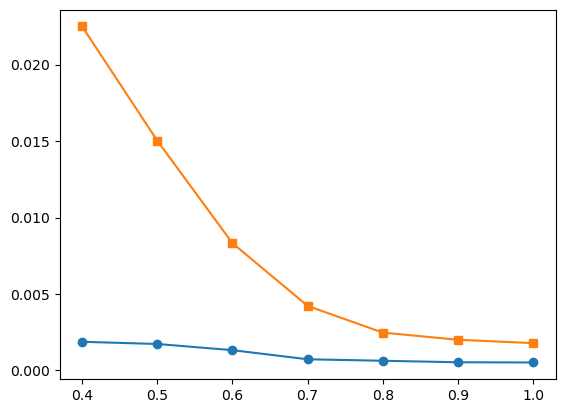

In [19]:
plt.plot(epsilons, mean_std, '-o', label='Cond-RR (std)')
plt.plot(epsilons, mean_bc,  '-s', label='Cond-RR (bias-corr)')